# Convection scheme downdrafts

Thomas Schanzer  
December 2021

In this notebook, we implement calculations for heterogeneous downdraft parcels, with the aim of using them in a convection parametrisation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import interp1d

from metpy.units import units, concatenate
import metpy.calc as mpcalc
from metpy.plots import SkewT
import metpy.constants as const

from dparcel.thermo import lcl_romps, moist_lapse, saturation_specific_humidity
from dparcel.environment import idealised_sounding
from dparcel.parcel import Parcel, FastParcel

## Summary of the method

The method is the one outlined in the Scheme Notes document.
1. `displaced_properties` determines the transfer matrices containing properties of environmental parcels displaced from level $i$ to $j$, without entrainment,
2. `transition_point` finds the point where the cloudy initial component of the heterogeneous parcel switches from moist adiabatic to dry adiabatic descent,
3. `nonentraining_properties` finds the properties of the cloudy initial component as a function of height, using `transition_point`,
4. `downdraft_properties` finds the temperature, specific humidity, liquid content, buoyancy and cloud fraction of the heterogeneous parcel at each model level, following Eq. (10) of Sherwood et al. (2013),
5. `downdraft_velocity` determines the vertical velocity profile, given the buoyancy from `downdraft_properties`.
6. `detrained_mass` determines the fraction of parcel mass detrained at each level.

Notable choices in this implementation are:
- For the transfer matrices, the LCL is found using the exact solution of Romps (2017) for speed, rather then using metpy.calc.parcel_profile which uses a slow iterative solution for the LCL
- The average properties of the heterogeneous parcel are computed using Simpson's rule to approximate the integral in Eq. (10) of Sherwood et al. (2013), rather than simply summing array elements. This should be more accurate, since the parcel entrains continuosly between levels rather than discretely at each level.
- Moist adiabatic descent is assumed to be pseudoadiabatic, and the calculations follow Davies-Jones (2008). This follows from our previous results showing that the use of reversible adiabats has only a very small impact on the simulated motion of downdraft parcels.

## Properties of displaced environmental parcels

In [2]:
def displaced_properties(pressure, temperature, specific_humidity):
    """
    Find the properties of displaced environmental parcels.
    
    Args:
        pressure: Increasing array of pressures at model levels.
        temperature: Array of corresponding temperatures.
        specific_humidity: Array of corresponding specific humidities.
        
    Returns:
        Arrays of temperatures, specific humidities and liquid water
        content with shape (pressure.size, pressure.size), where
        element (i,j) is the value attained by an environmental parcel
        moving adiabatically without entrainment from level i to
        level j.
        
    References:
        Romps, DM 2017, ‘Exact Expression for the Lifting Condensation
        Level’, Journal of the atmospheric sciences, vol. 74,
        no. 12, pp. 3891–3900.
    """
    if np.any(pressure[:-1] >= pressure[1:]):
        raise ValueError('Pressure array must be strictly increasing.')
    
    # Find the LCL using the exact solution of Romps (2017)
    p_lcl, t_lcl = lcl_romps(pressure, temperature, specific_humidity)
    lcl_index = np.searchsorted(pressure, p_lcl)
    
    # initialise empty arrays
    t_disp = np.zeros((pressure.size, pressure.size))*units.kelvin
    q_disp = np.zeros((pressure.size, pressure.size))*units.dimensionless
    l_disp = np.zeros((pressure.size, pressure.size))*units.dimensionless
    
    for i in range(pressure.size):
        if lcl_index[i] < pressure.size:
            # temperatures for j >= lcl_index[i], i.e., below the LCL,
            # are the dry adiabatic values
            t_disp[i,lcl_index[i]:] = mpcalc.dry_lapse(
                pressure[lcl_index[i]:], temperature[i],
                reference_pressure=pressure[i])
            # specific humidity is constant below the LCL and equal
            # to the initial environmental value
            q_disp[i,lcl_index[i]:] = specific_humidity[i]
        if lcl_index[i] > 0:
            # temperatures for j < lcl_index[i], i.e., above the LCL,
            # are the moist pseudoadiabatic values, starting from
            # the known pressure and temperature at the LCL
            t_disp[i,:lcl_index[i]] = moist_lapse(
                pressure[:lcl_index[i]], t_lcl[i],
                reference_pressure=p_lcl[i], method='fast')
            # the specific humidity is the saturation value
            q_disp[i,:lcl_index[i]] = saturation_specific_humidity(
                pressure[:lcl_index[i]], t_disp[i,:lcl_index[i]])
        # assuming total water is conserved, the final specific
        # humidity plus liquid water content equals the initial
        # specific humidity
        l_disp[i,:] = specific_humidity[i] - q_disp[i,:]
    
    # calculate virtual temperatures and buoyancy
    r_disp = mpcalc.mixing_ratio_from_specific_humidity(q_disp)
    tv_disp = mpcalc.virtual_temperature(t_disp, r_disp)
    r_env = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    tv_env = mpcalc.virtual_temperature(temperature, r_env)
    # note that the parcel arrays are 2D while the environment array
    # is 1D: the calculation is performed row-by-row on the 2D arrays,
    # not column-by-column
    b_disp = ((1 - l_disp)*tv_disp - tv_env)/tv_env*const.g
    
    return t_disp, q_disp, l_disp, b_disp

Testing on an idealised sounding:

In [3]:
env = idealised_sounding(0.5)
pressure = np.flip(env._pressure_raw*units.mbar)
temperature = np.flip(env._temperature_raw*units.celsius)
specific_humidity = env.specific_humidity(env.height(pressure))

In [4]:
%%time
t_disp, q_disp, l_disp, b_disp = displaced_properties(
    pressure, temperature, specific_humidity)

CPU times: user 1.61 s, sys: 13.2 ms, total: 1.62 s
Wall time: 1.63 s


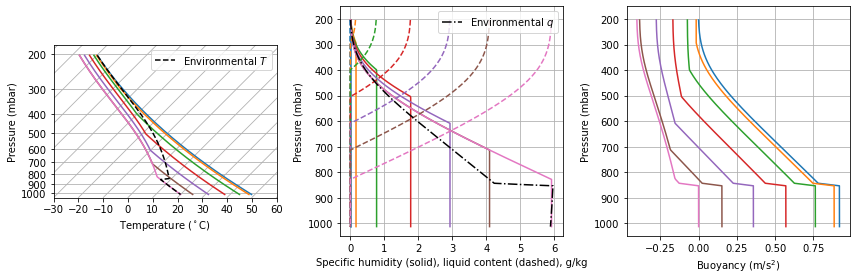

In [5]:
fig = plt.figure(figsize=(12,4))

skew = SkewT(fig, rotation=45, subplot=(1,3,1))
skew.plot(pressure, t_disp.T[:,::25])
skew.plot(pressure, temperature, 'k--', label='Environmental $T$')
skew.ax.legend()
skew.ax.set_xlim(-30, 60)
skew.ax.set_ylim(1050, 180)
skew.ax.set(xlabel='Temperature ($^\circ$C)', ylabel='Pressure (mbar)')

ax2 = fig.add_subplot(132)
ax2.plot(q_disp.T[:,::25]*1e3, pressure)
ax2.set_prop_cycle(None)
ax2.plot(l_disp.T[:,::25]*1e3, pressure, '--')
ax2.plot(specific_humidity*1e3, pressure, 'k-.', label='Environmental $q$')
ax2.set_ylim(1050, 150)
ax2.legend()
ax2.grid()
ax2.set(
    xlabel='Specific humidity (solid), liquid content (dashed), g/kg',
    ylabel='Pressure (mbar)')

ax3 = fig.add_subplot(133)
ax3.plot(b_disp.T[:,::25], pressure)
ax3.set_ylim(1050, 150)
ax3.grid()
ax3.set(xlabel='Buoyancy (m/s$^2$)', ylabel='Pressure (mbar)')

fig.tight_layout()
plt.show()

## Properties of heterogeneous downdraft parcels

In [6]:
def transition_point(pressure, p_initial, t_initial, q_initial, l_initial):
    """
    Finds the transition point between moist and dry descent.
    
    Only applies to non-entraining parcels.

    Args:
        p_initial: Starting pressure of the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.
        pressure: Increasing array of pressures at model levels.

    Returns:
        The pressure at which the liquid water ratio in the parcel
        becomes zero, and its temperature at that point.
        
    References:
        Romps, DM 2017, ‘Exact Expression for the Lifting Condensation
        Level’, Journal of the atmospheric sciences, vol. 74,
        no. 12, pp. 3891–3900.
    """
    if l_initial <= 0:
        # Romps (2017) LCL calculation is valid
        return lcl_romps(p_initial, t_initial, q_initial)

    # evaluate moist adiabatic values on a coarse array between
    # starting point and the surface in order to bracket the
    # transition point
    p_check = np.arange(
        p_initial.m_as(units.mbar), pressure[-1].m_as(units.mbar), 10
    )*units.mbar
    p_check = concatenate([p_check, pressure[-1]])
    t_moist = moist_lapse(
        p_check, t_initial, reference_pressure=p_initial, method='fast')
    l_moist = (
        q_initial + l_initial
        - saturation_specific_humidity(p_check, t_moist)
    )

    if l_moist[-1] > 0:
        # moist descent only
        return pressure[-1], t_moist[-1]

    # now find the transition point where l == 0
    if np.any(l_moist == 0):
        # check if we have already found the transition point
        return p_check[l_moist == 0][0], t_moist[l_moist == 0][0]

    # choose a suitable bracketing interval for the transition point.
    # out of the levels that give positive l_moist, use the one
    # that gives the smallest l_moist as one end of the interval
    guess_above = p_check[
        np.nanargmin(np.where(l_moist < 0, np.nan, l_moist))
    ]
    # out of the levels that give negative l_moist, use the one
    # that gives the largest l_moist as the other end
    guess_below = p_check[
        np.nanargmax(np.where(l_moist > 0, np.nan, l_moist))
    ]

    # evaluate the parcel properties on a finely spaced array within
    # the bracketing interval and interpolate to find the point of
    # l_moist == 0
    p_check = np.linspace(
        guess_above.m_as(units.mbar), guess_below.m_as(units.mbar), 100
    )*units.mbar
    t_moist = moist_lapse(
        p_check, t_initial, reference_pressure=p_initial, method='fast')
    l_moist = (
        q_initial + l_initial
        - saturation_specific_humidity(p_check, t_moist)
    )
    p_switch = interp1d(l_moist.m, p_check.m)(0)
    t_switch = interp1d(p_check.m, t_moist.m_as(units.kelvin))(p_switch)

    return p_switch.item()*units.mbar, t_switch.item()*units.kelvin

In [7]:
def nonentraining_properties(
        pressure, p_initial, t_initial, q_initial, l_initial):
    """
    Calculate the properties of a non-entraining parcel.

    Args:
        pressure: Array of pressures at model levels.
        p_initial: Starting pressure of the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.

    Returns:
        Arrays of parcel temperatures, specific humidities and
        liquid ratios at the levels of interest.
    """
    p_switch, t_switch = transition_point(
        pressure, p_initial, t_initial, q_initial, l_initial)
    
    t_final = np.zeros(pressure.size)*units.kelvin
    q_final = np.zeros(pressure.size)*units.dimensionless
    l_final = np.zeros(pressure.size)*units.dimensionless

    if np.any(pressure <= p_switch):
        # descent is moist adiabatic above the transition point
        t_final[pressure <= p_switch] = moist_lapse(
            pressure[pressure <= p_switch], t_switch,
            reference_pressure=p_switch, method='fast')
        q_final[pressure <= p_switch] = saturation_specific_humidity(
            pressure[pressure <= p_switch], t_final[pressure <= p_switch])
        l_final[pressure <= p_switch] = (
            q_initial + l_initial - q_final[pressure <= p_switch]
        )

    if np.any(pressure > p_switch):
        # descent is dry adiabatic below the transition point
        t_final[pressure > p_switch] = mpcalc.dry_lapse(
            pressure[pressure > p_switch], t_switch,
            reference_pressure=p_switch)
        q_final[pressure > p_switch] = saturation_specific_humidity(
            p_switch, t_switch)
        l_final[pressure > p_switch] = 0*units.dimensionless

    return t_final, q_final, l_final

In [8]:
def downdraft_properties(
        i_init, t_initial, q_initial, l_initial, pressure, height,
        temperature, specific_humidity, t_disp, q_disp, l_disp, b_disp,
        entrainment_rate):
    """
    Find the properties of a heterogeneous downdraft parcel.
    
    The method follows Section 4 of Sherwood et al. (2013).
    
    Args:
        i_init: Index of the starting level for the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.
        pressure: Increasing array of pressures at model levels.
        height: Array of heights of model levels.
        temperature: Array of corresponding temperatures.
        specific_humidity: Array of corresponding specific humidities.
        t_disp, q_disp, l_disp, b_disp: Array of displaced environmental
            properties obtained from displaced_properties.
        entrainment_rate: Entrainment rate.
        
    Returns:
        Arrays of length pressure.size containing the average
        temperature, specific humidity, liquid content and buoyancy
        of the parcel, weighted by the mass mixing fraction of the
        components, as well as the fraction by mass of the parcel that
        is cloudy.
    
    References:
        SHERWOOD, SC, HERNANDEZ-DECKERS, D, COLIN, M & ROBINSON, F 2013,
        ‘Slippery Thermals and the Cumulus Entrainment Paradox’, Journal
        of the atmospheric sciences, vol. 70, no. 8, pp. 2426–2442.
    """
    # find the properties of the non-entraining initial 'core' component
    # of the parcel
    t_core, q_core, l_core = nonentraining_properties(
        pressure, pressure[i_init], t_initial, q_initial, l_initial)
    r_core = mpcalc.mixing_ratio_from_specific_humidity(q_core)
    tv_core = mpcalc.virtual_temperature(t_core, r_core)
    r_env = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    tv_env = mpcalc.virtual_temperature(temperature, r_env)
    b_core = ((1 - l_core)*tv_core - tv_env)/tv_env*const.g
    
    # following Eq. (8), (9) of Sherwood et al. (2013):
    # mixing_fraction[i,j] is the proportion of air originally in the
    # parcel at height[i] that remains in the parcel after
    # ascent/descent to height[j], i.e.,
    # mixing_fraction[i,j] = exp(-eps|height[i] - height[j]|).
    mixing_fraction = np.exp(-entrainment_rate*np.abs(
        np.atleast_2d(height) - np.atleast_2d(height).T
    ))
    
    # initialise unused array entries as nan
    t_mix = np.full(pressure.size, np.nan)*units.kelvin
    q_mix = np.full(pressure.size, np.nan)*units.dimensionless
    l_mix = np.full(pressure.size, np.nan)*units.dimensionless
    b_mix = np.full(pressure.size, np.nan)*units.meter/units.second**2
    cloud_fraction = np.full(pressure.size, np.nan)*units.dimensionless
    # values at the initial height are the initial values, no entrainment
    t_mix[i_init] = t_core[i_init]
    q_mix[i_init] = q_core[i_init]
    l_mix[i_init] = l_core[i_init]
    b_mix[i_init] = b_core[i_init]
    for j in range(i_init+1, pressure.size):  # j is the destination level
        z_interval = height[i_init:j+1].m_as(units.meter)
        
        # following Eq. (10) of Sherwood et al. (2013):
        # integrate the contributions of environmental parcels that
        # are entrained in between the initial and final levels using
        # Simpson's rule
        t_integrand = (
            t_disp[i_init:j+1, j].T*entrainment_rate
            * mixing_fraction[i_init:j+1, j].T
        ).m_as(units.kelvin/units.meter)
        # add a negative sign to the integral since z_interval is
        # decreasing, not increasing
        t_integral = -simpson(t_integrand, z_interval)*units.kelvin
        t_mix[j] = t_core[j]*mixing_fraction[i_init, j] + t_integral
        
        # same procedure as above for the other variables
        q_integrand = (
            q_disp[i_init:j+1, j].T*entrainment_rate
            * mixing_fraction[i_init:j+1, j].T
        ).m_as(1/units.meter)
        q_integral = -simpson(q_integrand, z_interval)*units.dimensionless
        q_mix[j] = q_core[j]*mixing_fraction[i_init, j] + q_integral
        
        # l_integrand will usually be zero for downdrafts
        l_integrand = (
            l_disp[i_init:j+1, j].T*entrainment_rate
            * mixing_fraction[i_init:j+1, j].T
        ).m_as(1/units.meter)
        l_integral = -simpson(l_integrand, z_interval)*units.dimensionless
        l_mix[j] = l_core[j]*mixing_fraction[i_init, j] + l_integral
        
        b_integrand = (
            b_disp[i_init:j+1, j].T*entrainment_rate
            * mixing_fraction[i_init:j+1, j].T
        ).m_as(1/units.second**2)
        b_integral = -simpson(b_integrand, z_interval)
        b_integral *= units.meter/units.second**2
        b_mix[j] = b_core[j]*mixing_fraction[i_init, j] + b_integral
        
        if l_core[j] > 0:
            cloud_fraction[j] = mixing_fraction[i_init, j]
        else:
            cloud_fraction[j] = 0*units.dimensionless
        
    return t_mix, q_mix, l_mix, b_mix, cloud_fraction

Testing on an idealised sounding and comparing with previous methods:

In [9]:
env = idealised_sounding(0.5)
parcel = Parcel(env)
fastparcel = FastParcel(env)
pressure = np.flip(env._pressure_raw*units.mbar)
height = np.flip(env._height_raw*units.meter)
temperature = np.flip(env._temperature_raw*units.celsius)
specific_humidity = env.specific_humidity(env.height(pressure))

In [10]:
%%time
t_disp, q_disp, l_disp, b_disp = displaced_properties(
    pressure, temperature, specific_humidity)

CPU times: user 1.61 s, sys: 12.2 ms, total: 1.62 s
Wall time: 1.63 s


In [11]:
i_init = np.searchsorted(pressure, env.pressure(5*units.km))
t_initial = -13*units.celsius
q_initial = saturation_specific_humidity(pressure[i_init], t_initial)
l_initial = 2e-3*units.dimensionless
rate = 0.5/units.km

In [12]:
%%time
t_mix, q_mix, l_mix, b_mix, frac = downdraft_properties(
    i_init, t_initial, q_initial, l_initial, pressure, height, temperature,
    specific_humidity, t_disp, q_disp, l_disp, b_disp, rate)

CPU times: user 194 ms, sys: 4.5 ms, total: 198 ms
Wall time: 199 ms


In [13]:
t_orig = np.full(pressure.size, np.nan)*units.kelvin
q_orig = np.full(pressure.size, np.nan)*units.dimensionless
l_orig = np.full(pressure.size, np.nan)*units.dimensionless
b_orig = np.full(pressure.size, np.nan)*units.meter/units.second**2
t_orig[i_init:], q_orig[i_init:], l_orig[i_init:] = parcel.profile(
    height[i_init:], t_initial, q_initial, l_initial, rate)
b_orig[i_init:] = parcel.buoyancy(
    height[i_init:], height[i_init], t_initial, q_initial, l_initial, rate)

In [14]:
t_fast = np.full(pressure.size, np.nan)*units.kelvin
q_fast = np.full(pressure.size, np.nan)*units.dimensionless
l_fast = np.full(pressure.size, np.nan)*units.dimensionless
b_fast = np.full(pressure.size, np.nan)*units.meter/units.second**2
theta_e = fastparcel.equivalent_potential_temperature(
    height[i_init], t_initial, q_initial, rate)
water = fastparcel.water_content(height[i_init], q_initial, l_initial, rate)
z_switch, t_switch = fastparcel.transition_point(
    height[i_init], t_initial, l_initial, theta_e, water)
t_fast[i_init:], q_fast[i_init:], l_fast[i_init:] = fastparcel.properties(
    height[i_init:], height[i_init], t_initial, z_switch, t_switch,
    theta_e, water)
b_fast[i_init:] = fastparcel.buoyancy(
    height[i_init:], height[i_init], t_initial, z_switch, t_switch,
    theta_e, water)

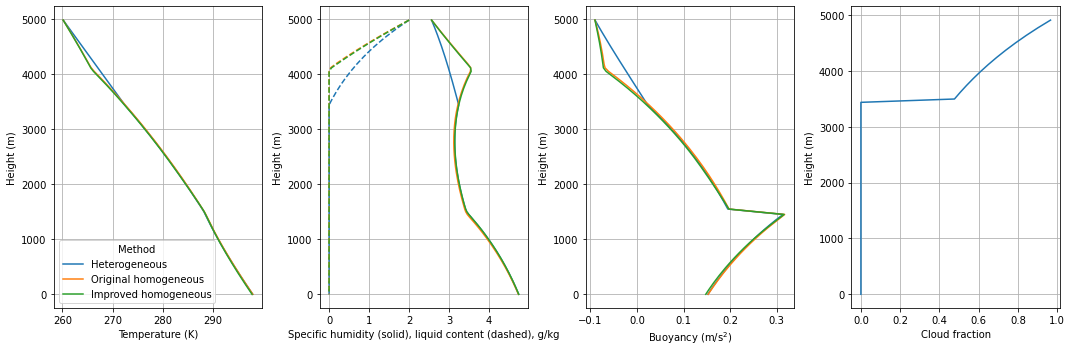

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))

ax1.plot(t_mix, height, label='Heterogeneous')
ax1.plot(t_orig, height, label='Original homogeneous')
ax1.plot(t_fast, height, label='Improved homogeneous')
lgd = ax1.legend()
lgd.set_title('Method')
ax1.grid()
ax1.set(xlabel='Temperature (K)', ylabel='Height (m)')

ax2.plot(q_mix*1e3, height)
ax2.plot(q_orig*1e3, height)
ax2.plot(q_fast*1e3, height)
ax2.set_prop_cycle(None)
ax2.plot(l_mix*1e3, height, '--')
ax2.plot(l_orig*1e3, height, '--')
ax2.plot(l_fast*1e3, height, '--')
ax2.grid()
ax2.set(xlabel='Specific humidity (solid), liquid content (dashed), g/kg',
        ylabel='Height (m)')

ax3.plot(b_mix, height)
ax3.plot(b_orig, height)
ax3.plot(b_fast, height)
ax3.grid()
ax3.set(xlabel='Buoyancy (m/s$^2$)', ylabel='Height (m)')

ax4.plot(frac, height)
ax4.grid()
ax4.set(xlabel='Cloud fraction', ylabel='Height (m)')

fig.tight_layout()

We note that the heterogeneous parcel evaporates its liquid water at a much slower rate. We propose that this is a result of the components of the heterogeneous parcel not being able to mix; the introduction of subsaturated environmental air cannot aid evaporation.

## Vertical velocity profile

The vertical velocity $w$ for an updraft satisfies the ODE
$$\frac{\mathrm{d}w}{\mathrm{d}z} = \frac{B(z)}{w} - \epsilon_w w $$
(Eq. (10), Sherwood et al. (2013)) where $B(z)$ is the buoyancy, which is only known for a discrete set of $z$, and $\epsilon_w$ is the drag coefficient.

We may make the substitution $v = w^2$ and express $w$ in terms of an integral using the integrating factor method:
$$
\begin{align}
    w \frac{\mathrm{d}w}{\mathrm{d}z} = \frac{1}{2} \frac{\mathrm{d}}{\mathrm{d}z} (w^2)
    = \frac{1}{2} \frac{\mathrm{d}v}{\mathrm{d}z}
    &= B(z) - \epsilon_w w^2 = B(z) - \epsilon_w v\\
    \Leftrightarrow \qquad
    e^{2\epsilon_w z} \frac{\mathrm{d}v}{\mathrm{d}z} + 2\epsilon_w e^{2\epsilon_w z} v
    = \frac{\mathrm{d}}{\mathrm{d}z} \left( e^{2\epsilon_w z} v \right)
    &= 2 e^{2\epsilon_w z} B(z) \\
    \Leftrightarrow \qquad
    e^{2\epsilon_w z} v(z) - e^{2\epsilon_w z_0} v(z_0)
    &= 2 \int_{z_0}^z e^{2\epsilon_w z'} B(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    v(z) &= e^{2\epsilon_w (z_0 - z)} v(z_0) + 2 e^{-2\epsilon_w z} \int_{z_0}^z e^{2\epsilon_w z'} B(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    w(z) &= \sqrt{e^{2\epsilon_w (z_0 - z)} w_0^2 + 2 e^{-2\epsilon_w z} \int_{z_0}^z e^{2\epsilon_w z'} B(z') ~\mathrm{d}z'},
\end{align}
$$
where the integral may be approximated using Simpson's rule.

For a downdraft, we have
$$
\begin{align}
    \frac{1}{2} \frac{\mathrm{d}v}{\mathrm{d}z}
    &= B(z) + \epsilon_w w^2 = B(z) + \epsilon_w v\\
    \Leftrightarrow \qquad
    e^{-2\epsilon_w z} \frac{\mathrm{d}v}{\mathrm{d}z} - 2\epsilon_w e^{-2\epsilon_w z} v
    = \frac{\mathrm{d}}{\mathrm{d}z} \left( e^{-2\epsilon_w z} v \right)
    &= 2 e^{-2\epsilon_w z} B(z) \\
    \Leftrightarrow \qquad
    e^{-2\epsilon_w z} v(z) - e^{-2\epsilon_w z_0} v(z_0)
    &= 2 \int_{z_0}^z e^{-2\epsilon_w z'} B(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    v(z) &= e^{2\epsilon_w (z - z_0)} v(z_0) + 2 e^{2\epsilon_w z} \int_{z_0}^z e^{-2\epsilon_w z'} B(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    w(z) &= -\sqrt{e^{2\epsilon_w (z - z_0)} w_0^2 + 2 e^{2\epsilon_w z} \int_{z_0}^z e^{-2\epsilon_w z'} B(z') ~\mathrm{d}z'},
\end{align}
$$

In [16]:
def downdraft_velocity(
        i_init, w_initial, buoyancy, height, drag=0/units.meter):
    """
    Determine the downdraft velocity profile directly.
    
    Args:
        i_init: Index of the starting level.
        w_initial: Initial velocity. Should be non-positive.
        buoyancy: Array of parcel buoyancies at the given heights.
        height: Array of heights at which the buoyancy is sampled.
        drag: The drag coefficient.
        
    Returns:
        An array of length height.size containing the velocity profile,
        with entries above i_init equal to np.nan. Any entries below
        the minimum height reached will also be np.nan.
    """
    velocity = np.full(height.size, np.nan)*units.meter/units.second
    velocity[i_init] = w_initial
    for j in range(i_init+1, height.size):
        # implementation of the analytic solution using the integrating
        # factor method, approximating the integral using Simpson's
        # rule
        integrand = np.exp(-2*drag*height[i_init:j+1])*buoyancy[i_init:j+1]
        integral = simpson(
            integrand.m_as(units.meter/units.second**2),
            height[i_init:j+1].m_as(units.meter)
        )*units.meter**2/units.second**2
        v_squared = (
            np.exp(2*drag*(height[j] - height[i_init]))*w_initial**2
            + 2*np.exp(2*drag*height[j])*integral
        )
        
        # v^2 < 0 indicates the thermal cannot reach that level
        velocity[j] = -np.sqrt(v_squared) if v_squared >= 0 else np.nan
    return velocity

In [17]:
time = np.arange(0, 10*60, 5)*units.second
w_initial = 0*units.meter/units.second

In [46]:
w_analytic = downdraft_velocity(i_init, w_initial, b_mix, height)

In [19]:
sol_orig = parcel.motion(
    time, height[i_init], w_initial, t_initial, q_initial, l_initial,
    rate)
w_orig = sol_orig.velocity
z_orig = sol_orig.height

In [20]:
sol_fast = fastparcel.motion(
    time, height[i_init], w_initial, t_initial, q_initial, l_initial,
    rate)
w_fast = sol_fast.velocity
z_fast = sol_fast.height

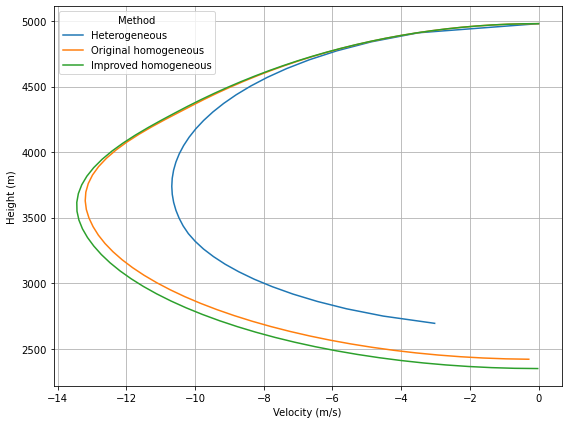

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(w_analytic, height, label='Heterogeneous')
ax.plot(w_orig, z_orig, label='Original homogeneous')
ax.plot(w_fast, z_fast, label='Improved homogeneous')
ax.grid()
lgd = ax.legend()
lgd.set_title('Method')
ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
fig.tight_layout()
plt.show()

As a result of the heterogeneous parcel's smaller negative buoyancy, it achieves lower velocities than the homogeneous parcels.

## Detrainment profile
Let $m$ be the mass of the thermal. Then, for a downdraft,
$$
\begin{align}
    \frac{\mathrm{d}m}{\mathrm{d}z} &= m \nu(z) \\
    \Leftrightarrow \qquad
    \int_{m_0}^m \frac{\mathrm{d}m'}{m'} = \log \left( \frac{m}{m_0} \right)
    &= \int_{z_0}^z \nu(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    \frac{m}{m_0} &= \exp \left( \int_{z_0}^z \nu(z') ~\mathrm{d}z' \right)
\end{align}    
$$
and for an updraft
$$
\begin{align}
    \frac{\mathrm{d}m}{\mathrm{d}z} &= -m \nu(z) \\
    \Leftrightarrow \qquad
    \int_{m_0}^m \frac{\mathrm{d}m'}{m'} = \log \left( \frac{m}{m_0} \right)
    &= -\int_{z_0}^z \nu(z') ~\mathrm{d}z' \\
    \Leftrightarrow \qquad
    \frac{m}{m_0} &= \exp \left( -\int_{z_0}^z \nu(z') ~\mathrm{d}z' \right)
\end{align}    
$$
We assume that the mass $\delta(m/m_0)_j$ deposited into level $j$ is equal to the mass lost between the level interfaces at $z_j^-$ (above) and $z_j^+$ (below). We assume that $\delta z_j = z_j^- - z_j^+ \approx (z_{j-1} - z_{j+1})/2$ so that
$$
    \delta \left( \frac{m}{m_0} \right)_j \approx \frac{m(z_j)}{m_0} \nu(z_j) \delta z_j
    \approx \frac{m(z_j)}{m_0} \nu(z_j) \frac{z_{j-1} - z_{j+1}}{2}.
$$
TODO: thermals stop when w reaches zero (bottom), and all air at that point is detrained uniformly between bottom and LNB?

In [59]:
def detrained_mass(height, velocity, buoyancy, dnu_db):
    """
    Calculate the fractional mass detrained from a thermal at each level.
    
    Args:
        height: Array of heights at model levels.
        velocity: Vertical velocity of the thermal at each level,
            obtained from downdraft_velocity.
        buoyancy: Buoyancy of the thermal at each level.
        dnu_db: The proportionality constant defining the detrainent
            rate nu. When the buoyancy b is negative, nu is zero,
            and when b > 0, nu = b*dnu_db. The units of dnu_db should be
            s^2/m^2.
            
    Returns:
        An array of mass detrained at each level, as a fraction of the
        original mass. 
    """
    # determine the detrainment rate nu:
    # nu = 0 if b < 0, b*dnu_db if b > 0
    nu = np.maximum(buoyancy, 0*units.meter/units.second**2)*dnu_db
    
    # velocity is nan for the levels the thermal does not reach:
    # use this to identify starting and ending levels
    reached_levels = np.argwhere(~np.isnan(velocity))
    i_init = np.min(reached_levels)
    i_end = np.max(reached_levels)
    
    m_remaining = np.zeros(height.size)*units.dimensionless
    m_remaining[i_init] = 1*units.dimensionless  # start with 100% mass
    for j in range(i_init+1, i_end+1):
        # fractional mass remaining = exp(integral_{z_0}^z nu(z') dz')
        integral = simpson(
            nu[i_init:j+1].m_as(1/units.meter),
            height[i_init:j+1].m_as(units.meter))
        m_remaining[j] = np.exp(integral*units.dimensionless)
        
    # thickness of level j is approx. (z_j-1 - z_j+1)/2.
    # pad ends with zeroes to keep same length
    thickness = np.pad((height[:-2] - height[2:])/2, 1)
    thickness[0] = height[0] - height[1]  # topmost layer
    thickness[-1] = height[-2] - height[-1]  # surface layer
    # change in fractional mass is approx. m * nu * delta z
    m_deposited = m_remaining*nu*thickness
    return np.where(np.isnan(m_deposited), 0*units.dimensionless, m_deposited)

In [60]:
m_detrained = detrained_mass(
    height, w_analytic, b_mix, 3e-2*units.second**2/units.meter**2)

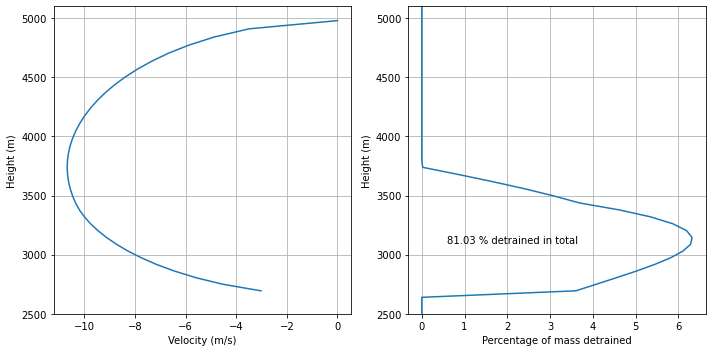

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(w_analytic, height)
ax1.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
ax2.plot(m_detrained*1e2, height)
ax2.set(xlabel='Percentage of mass detrained', ylabel='Height (m)')
ax2.text(0.6, 3100,
         '{:.2f} % detrained in total'.format(np.sum(m_detrained.m)*1e2))
ax1.set_ylim(2500, 5100)
ax2.set_ylim(2500, 5100)
ax1.grid()
ax2.grid()
fig.tight_layout()

## Next step
- Extend to updrafts (should not be too difficult)